# Cython

Being a C program, Python has powerful and well developed C API, which allows writing C extensions modules. However, Python C API is considered an advanced topic and development of C extensions is slow and error-prone.

Cython is a Static compiler for Python. It allows to write Python C extensions with less effort compared to traditional Python C API way.

General Cython pipeline looks as the following:

- you develop some code in pure Python and **profile** it with `line_profiler` to catch hotspots,
- you decide on the strategy to optimize your code. Typically, this would involve **adding type information**, and using **typed memoryviews** instead of NumPy arrays,
- then you generate C extension module from Cython code and test its performance. If it ok - end of the story, if it's not, you continue.

Cython knows a lot about NumPy arrays and allows to interface with them easily. Cython code itself looks a lot like a mixture of C and Python. Cython compiler generates C extensions code from Cython code and compiles it with system compiler as a lloadable C extension.

In this material, we will use `Cython` extension for Jupyter to avoid writing modules and compile them with `setup.py` (although that's also simple enough). This may not work on Windows very well, as Cython requires C compiler to generate extension modules from C code, and it sometimes tricky to setup correctly on Windows.

# Matrix multiplication

We will implement matrix multiplication using Cython. We'll start with naive and straightforward implementation, measure it's performance and compare it with `np.dot` performance. Then, we will try to improve it using smarter memory access pattern.

In [1]:
%pylab inline
plt.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np

We need some tools to measure performance, so that we can plot running time to see the pattern. Although there are many different ways to do this, we will use `%timeit`. Note, that we can catch output from `%timeit`:

In [3]:
arr = np.random.randn(1000,1000)

In [4]:
# Returns TimeitResult object
s = %timeit -n 10 -r 3 -o np.dot(arr, arr)

65.8 ms ± 9.36 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)


In [5]:
s.average

0.0657874778994786

## Problem with matrix multiplication

Product of matrices $A$ and $B$ is a matrix $C$:

$$C_{ik} = A_{ij}B_{jk}.$$

You can immediately spot the problem here. If both matrices are in row-major order, $B$ is accessed in wrong direction: you hop through array rows, which leads to a lot of cache misses.

Anyway, it's interesting to understand, how naive implementation performs. Let's do that.

## Typed memoryviews

To represent homogeneous buffer of data (which `numpy` arrays are!) in Cython, we have what is called [_typed memoryview_](https://cython.readthedocs.io/en/latest/src/userguide/memoryviews.html). Typed memoryview is a handle to underlying buffer of Python object, if there's a buffer, of course (`array` from standard library will work as well). Consult typed memoryviews docs to understand the declaration structure.

We first import `Cython` extension. `Cython` extension does all the job for us: generates C extension module, compiles it and loads the function as needed.

In [6]:
%load_ext Cython

To see some hints from Cython we will use **annotations** (`--annotate` key). With this option, Cython will mark all the Python interaction in yellow. Generally, using functions from Python interpreter itself should be avoided, as they go throught Python stack and are hence slow. You can click on `+` in the output to see the actual C code generated by Cython:

In [7]:
%%cython --annotate
# In this function we have memoryview of buffer of doubles as an argument
def sum_arr(double[:] a):
    """Sum elements of `a`."""

    result = 0.

    # Note, that typed memoryviews know about shape
    for i in range(a.shape[0]):
        result += a[i]
    return result

In [8]:
# BTW, why do we need to flatten our array?
arr_f = arr.flatten()
sum_arr(arr_f), arr.sum()

(-696.1862001563478, -696.1862001563177)

In [9]:
%timeit -n 100 -r 3 sum_arr(arr_f)

30.1 ms ± 2.66 ms per loop (mean ± std. dev. of 3 runs, 100 loops each)


In [10]:
%timeit -n 100 -r 3 arr.sum()

871 µs ± 114 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)


As you can see, not only our function is much slower, but it's also (see annotation) a bit too Pythonic. It uses usual Python `float` functions to add new element to `result`.

You should be careful enough using the tools below, but generally it's quite safe to use them with typed memoryviews (but remember, that other objects may also be in scope, those, which do not know about their shape). So, we will skip bounds check. Wow, right?

We will also make result a usual C `double`.`@boundscheck(False)` decorator skips all checks, related to whether you're accessing your buffer within bounds. `@wraparound` decorator deactivates negative indexing. as we do not use them and there's no need to check is they are used correctly:

In [11]:
%%cython --annotate
from cython cimport boundscheck, wraparound

@boundscheck(False)
@wraparound(False)
def sum_arr_c(double[:] a):
    """Sum elements of `a`."""

    cdef double result = 0.

    # Note, that typed memoryviews know about shape
    for i in range(a.shape[0]):
        result += a[i]
    return result

Much better, right? Take some time to try to understand C code in annotations and get the idea about the difference between two versions of the function.

In [12]:
sum_arr(arr_f), sum_arr_c(arr_f), arr.sum()

(-696.1862001563478, -696.1862001563478, -696.1862001563177)

In [13]:
%timeit -n 100 -r 3 sum_arr_c(arr_f)

1.57 ms ± 100 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)


Note, that Cython does transformation from C `double` to Python `float` for you:
    
```c
__pyx_t_5 = PyFloat_FromDouble(__pyx_v_result); if (unlikely(!__pyx_t_5)) __PYX_ERR(0, 12, __pyx_L1_error)
```

Note, that we reached almost NumPy performance with one type annotation and two decorators.

BTW, do you understand, why results between our function and `np.sum` are slightly different? Think about this for a moment (or Google it!).

So, we have a function, which is still slightly worse, than `numpy` equivalent. But we got here without a lot of efforts (and we are actually competing with the ones of the best developers in the world, although using the tools by other brilliant developers).

To be able to profile our Cython code with `line_profiler`, we need to add additional lines:

In [14]:
%%cython --annotate -f
# cython: profile=True
# cython: linetrace=True
# cython: binding=True
# distutils: define_macros=CYTHON_TRACE_NOGIL=1

from cython cimport boundscheck, wraparound

@boundscheck(False)
@wraparound(False)
def sum_arr_c(double[:] a):
    """Sum elements of `a`."""

    cdef double result = 0.
    cdef int i

    # Note, that typed memoryviews know about shape
    for i in range(a.shape[0]):
        result += a[i]
    return result

In [15]:
%timeit -n 100 -r 3 sum_arr_c(arr_f)

1.7 ms ± 42.6 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)


In [16]:
%load_ext line_profiler

In [17]:
%lprun -f sum_arr_c sum_arr_c(arr_f)

Our summation function can be implemented in `numpy` array specific way (and it  then won't work with standard Python arrays, for example):

In [18]:
%%cython --annotate
# cython: profile=True
# cython: linetrace=True
# cython: binding=True
# distutils: define_macros=CYTHON_TRACE_NOGIL=1

from cython cimport boundscheck, wraparound
import numpy as np
cimport numpy as np

@boundscheck(False)
@wraparound(False)
def sum_arr_np(np.ndarray[np.float64_t, ndim=1] a):
    """Sum elements of `a`."""

    cdef double result = 0.
    cdef int i

    # numpy arrays also know about shape, of course
    for i in range(a.shape[0]):
        result += a[i]
    return result

In [19]:
%timeit -n 100 -r 3 sum_arr_np(arr_f)

1.69 ms ± 17.1 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)


In [20]:
%lprun -f sum_arr_np sum_arr_np(arr_f)

Now that we know something about Cython and typed memoryviews, we can go on and try to implement matrix multiplication!

# Implementing matrix product

We'll do the naive version of matrix multiplication, which just implements general formula for matrix product. Although naive, we'll add some optimizations later to have better memory access.

In [21]:
%%cython --annotate

from cython cimport boundscheck, wraparound
import numpy as np
cimport numpy as np

@boundscheck(False)
@wraparound(False)
def mat_mult(double[:, :] a, double[:, :] b):
    """Calculate matrix product."""

    # Add some code to check dimensions here
    # We really need to check dimensions of matrices
    # Cause we disabled bounds check
    # a.shape[1]==b.shape[0]?
        
    cdef double[:, :] result = np.zeros((a.shape[0], b.shape[1]))
    cdef double accum
    cdef int i, j, k
    cdef double ak, bk

    # Outer loop: rows of a
    for i in range(a.shape[0]):
        # First inner loop: columns of b
        for j in range(b.shape[1]):
            accum = 0
            # Inner loop: product of row i of a and column j of b
            for k in range(a.shape[1]):
                accum += a[i, k]*b[k, j]
            result[i, j] = accum
    return np.asarray(result)

Our function quite C-ish. But is it fast?

In [22]:
a = np.random.randn(300, 500)
b = np.random.randn(500, 700)

In [23]:
np.allclose(mat_mult(a, b), np.dot(a, b))

True

In [24]:
%timeit -n 10 -r 3 mat_mult(a, b)

262 ms ± 31.9 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)


In [25]:
%timeit -n 10 -r 3 np.dot(a, b)

13.4 ms ± 2.76 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)


Not that fast, right? Why our function is so slow? Let's perform an experiment. We will change the way `b` is stored, so that indexing order for `b` is efficient:

In [26]:
b_t = np.asfortranarray(b)

In [27]:
%timeit -n 10 -r 3 mat_mult(a, b_t)

145 ms ± 10.3 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)


Timing should be much smaller now. Surprising enough? Actually, no, it's not. By default, arrays are stored in C-order (row-major), so that stride for last array dimension is the smallest. If we change that to F-order, we suddenly make memory access for `b` much more efficient. Add this to our function, so that we do not need to do it manually:

In [28]:
%%cython --annotate
# cython: profile=True
# cython: linetrace=True
# cython: binding=True
# distutils: define_macros=CYTHON_TRACE_NOGIL=1

from cython cimport boundscheck, wraparound
import numpy as np
cimport numpy as np

@boundscheck(False)
@wraparound(False)
def mat_mult_t(double[:, ::1] a, double[:, ::1] b):
    """Calculate matrix product."""

    # Add some code to check dimensions here
    # We really need to check dimensions of matrices
    # Cause we disabled bounds check
    # a.shape[1]==b.shape[0]?

    cdef double[::1, :] b_t = np.asfortranarray(b)
        
    cdef double[:, :] result = np.zeros((a.shape[0], b.shape[1]))
    cdef double accum, ak, bk
    cdef int i, j, k

    # Outer loop: rows of a
    for i in range(a.shape[0]):
        # First inner loop: columns of b
        for j in range(b_t.shape[1]):
            accum = 0
            # Inner loop: product of row i of a and column j of b
            for k in range(a.shape[1]):
                accum += a[i, k]*b_t[k, j]
            result[i, j] = accum
    return np.asarray(result)

In [29]:
%timeit -n 10 -r 3 mat_mult_t(a, b)

157 ms ± 18.1 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)


In [30]:
np.allclose(mat_mult_t(a, b), np.dot(a, b))

True

Let's profile our latest version of matrix product line by line:

In [31]:
%lprun -f mat_mult_t mat_mult_t(a, b)

Let's investigate, how running time depends on matrix shape:

In [32]:
# New cool package here: now we have nice progress bars
from tqdm import tqdm

In [33]:
timings = []

for i in tqdm(range(50, 1050, 50)):
    c = np.random.randn(i, i)
    t_np = %timeit -n 10 -r 3 -o -q np.dot(c, c)
    t_cy = %timeit -n 10 -r 3 -o -q mat_mult_t(c, c)
    timings.append([i, t_np.average, t_cy.average])

100%|██████████| 20/20 [03:58<00:00, 11.91s/it]


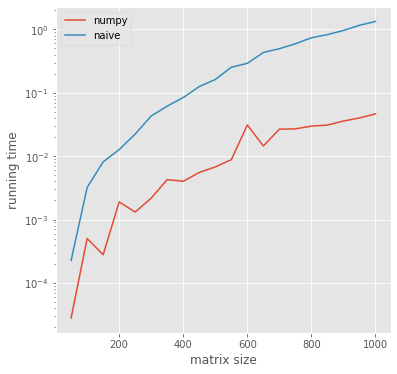

In [34]:
timings = np.array(timings)

plt.figure(figsize=(6,6))
plt.plot(timings[:, 0], timings[:, 1], label='numpy')
plt.plot(timings[:, 0], timings[:, 2], label='naive')
plt.yscale('log')
plt.legend(loc=0)
plt.xlabel('matrix size')
plt.ylabel('running time');

On the next step we may try to implement tiled matrix multiplication. But is it worth it? I'll provide an implementation, so that you can try, but generally our access pattern is already good enough for cache.

## Tiled matrix multiplication

In [35]:
%%cython --annotate
# cython: profile=True
# cython: linetrace=True
# cython: binding=True
# distutils: define_macros=CYTHON_TRACE_NOGIL=1

from cython cimport boundscheck, wraparound
import numpy as np
cimport numpy as np

@boundscheck(False)
@wraparound(False)
def mat_mult_tiled(double[:, ::1] a, double[:, ::1] b,
               int tile_t):
    """Calculate matrix product."""

    # Add some code to check dimensions here
    # We really need to check dimensions of matrices
    # Cause we disabled bounds check
    # a.shape[1]==b.shape[0]?


    cdef double[::1, :] b_t = np.asfortranarray(b)

    cdef double[:, :] result = np.zeros((a.shape[0], b.shape[1]))
    cdef double accum, ak, bk
    cdef int ait, ajt, at_dim_0, at_dim_1, ai
    cdef int bit, bjt, bt_dim_0, bt_dim_1, bj, k, kdim

    # Outer loop: row tile of a
    for ait in range(0, a.shape[0], tile_t):
        at_dim_0 = min(tile_t,  a.shape[0] - ait)

        # First inner loop: column tile of b
        for bjt in range(0, b.shape[1], tile_t):
            bt_dim_1 = min(tile_t,  b.shape[1] - bjt)
            
            # Second inner loop: column tile of a
            for ajt in range(0, a.shape[1], tile_t):
                at_dim_1 = min(tile_t,  a.shape[1] - ajt)
                
                # Tile matrix multiplication
                for ai in range(ait, ait+at_dim_0):
                    for bj in range(bjt, bjt+bt_dim_1):
                        accum = 0
                        for k in range(at_dim_1):
                            accum += a[ai, ajt+k]*b_t[ajt+k, bj]
                        result[ai, bj] += accum
    return np.asarray(result)

In [36]:
%timeit -n 3 -r 3 mat_mult_tiled(a, b, 256)

160 ms ± 20.9 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [37]:
np.allclose(mat_mult_tiled(a, b, 256), np.dot(a, b))

True

In [38]:
%lprun -f mat_mult_tiled mat_mult_tiled(a, b, 64)

In [39]:
timings = []

for i in tqdm(range(64, 576, 64)):
    c = np.random.randn(1000, 1000)
    t_cy = %timeit -n 10 -r 3 -o -q mat_mult_tiled(c, c, i)
    timings.append([i, t_cy.average])

100%|██████████| 8/8 [05:42<00:00, 42.84s/it]


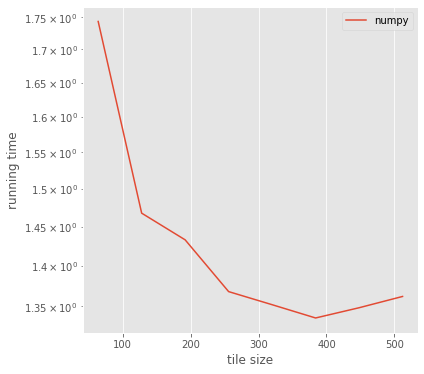

In [40]:
timings = np.array(timings)

plt.figure(figsize=(6,6))
plt.plot(timings[:, 0], timings[:, 1], label='numpy')
plt.yscale('log')
plt.legend(loc=0)
plt.xlabel('tile size')
plt.ylabel('running time');

As you can see, there was no need to add tiling for matrices of size we use. However, for larger matrices it may actually be worth it.

# All at once

Let's create clean versions (without tracing and all of that) of our two implementations:

In [41]:
%%cython
from cython cimport boundscheck, wraparound
import numpy as np
cimport numpy as np

@boundscheck(False)
@wraparound(False)
def mat_mult_tiled(double[:, ::1] a, double[:, ::1] b,
               int tile_t):
    """Calculate matrix product."""

    # Add some code to check dimensions here
    # We really need to check dimensions of matrices
    # Cause we disabled bounds check
    # a.shape[1]==b.shape[0]?
    
    cdef double[::1, :] b_t = np.asfortranarray(b)
        
    cdef double[:, ::1] result = np.zeros((a.shape[0], b.shape[1]))
    cdef double accum, ak, bk
    cdef int ait, ajt, at_dim_0, at_dim_1, ai
    cdef int bit, bjt, bt_dim_0, bt_dim_1, bj, k, kdim

    # Outer loop: row tile of a
    for ait in range(0, a.shape[0], tile_t):
        at_dim_0 = min(tile_t,  a.shape[0] - ait)
        
        # First inner loop: column tile of b
        for bjt in range(0, b.shape[1], tile_t):
            bt_dim_1 = min(tile_t,  b.shape[1] - bjt)
            
            # Second inner loop: column tile of a
            for ajt in range(0, a.shape[1], tile_t):
                at_dim_1 = min(tile_t,  a.shape[1] - ajt)
                
                # Tile matrix multiplication
                for ai in range(ait, ait+at_dim_0):
                    for bj in range(bjt, bjt+bt_dim_1):
                        accum = 0
                        for k in range(at_dim_1):
                            accum += a[ai, ajt+k]*b_t[ajt+k, bj]
                        result[ai, bj] += accum
    return np.asarray(result)

@boundscheck(False)
@wraparound(False)
def mat_mult_t(double[:, ::1] a, double[:, ::1] b):
    """Calculate matrix product."""

    # Add some code to check dimensions here
    # We really need to check dimensions of matrices
    # Cause we disabled bounds check
    # a.shape[1]==b.shape[0]?
    
    cdef double[::1, :] b_t = np.asfortranarray(b)
        
    cdef double[:, :] result = np.zeros((a.shape[0], b.shape[1]))
    cdef double accum, ak, bk
    cdef int i, j, k

    # Outer loop: rows of a
    for i in range(a.shape[0]):
        # First inner loop: columns of b
        for j in range(b_t.shape[1]):
            accum = 0
            # Inner loop: product of row i of a and column j of b
            for k in range(a.shape[1]):
                accum += a[i, k]*b_t[k, j]
            result[i, j] = accum
    return np.asarray(result)

And let's create Numba version to see, what we can get for free. Numba is a JIT compiler for Python. In its basic form it allows to add a JIT decorator to any function, and that function will be JIT-compiled. However, Numba works great NumPy, but cannot optimize Pandas.

In [42]:
from numba import jit, prange

@jit(parallel=True)
def mat_mult_numba(a, b):
    """Sum elements of `a`."""

    # Add some code to check dimensions here
    # We really need to check dimensions of matrices
    # Cause we disabled bounds check
    # a.shape[1]==b.shape[0]?
        
    result = np.zeros((a.shape[0], b.shape[1]))

    # b_t code here

    # Outer loop: rows of a
    for i in prange(a.shape[0]):
        # First inner loop: columns of b
        for j in range(b.shape[1]):
            accum = 0
            # Inner loop: product of row i of a and column j of b
            for k in range(a.shape[1]):
                ak = a[i, k]
                bk = b_t[k, j]
                accum += ak*bk
            result[i, j] = accum
    return result

In [43]:
%timeit -n 10 -r 3 np.dot(a, b)

9.72 ms ± 662 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)


In [44]:
%timeit -n 10 -r 3 mat_mult_t(a, b)

140 ms ± 7.79 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)


In [45]:
np.allclose(mat_mult_t(a, b), np.dot(a, b))

True

In [46]:
%timeit -n 10 -r 3 mat_mult_tiled(a, b, 256)

136 ms ± 8.02 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)


In [47]:
np.allclose(mat_mult_tiled(a, b, 256), np.dot(a, b))

True

In [48]:
np.allclose(mat_mult_numba(a, b), np.dot(a, b))

True

In [49]:
%timeit -n 10 -r 3 mat_mult_numba(a, b)

48.5 ms ± 13 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)


On instructor's machine the results are the following:

- `np.dot`: **9.72ms**,
- naive Cython implementation with `b` in F-order layout: **140ms**,
- tiled Cython implementation with `b` in F-order layout: **136ms**,
- parallel Numba implementation: **48.5ms**.

To understand, what we are competing with (depending on your system, this may give different results):

In [50]:
np.show_config()

blas_mkl_info:
  NOT AVAILABLE
blis_info:
  NOT AVAILABLE
openblas_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
blas_opt_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
lapack_mkl_info:
  NOT AVAILABLE
openblas_lapack_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
lapack_opt_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]


Although it's hard to beat NumPy (hence, BLAS and other battle-tested libraries for linear algebra), we were close enough with very simple implementation. For custom algorithms Cython may be indispensable, and even more so - for wrapping available C libraries, as it allows to link to them. This is possible, because Cython generates C code, and everything (or, better to say, almost everything), which is possible to use in any C code, is available in Cython.